#### Day of the week effect
In this exercise, you are asked to obtain some stock market data and consider whether average returns differ by the day of the week.

1. Please download daily data of portfolios sorted by size (i.e. ME = market equity) from the Kenneth French data library. You will use the value-weighted portfolios throughout this problem set. For each of the decile portfolios, make a boxplot.

<AxesSubplot:>

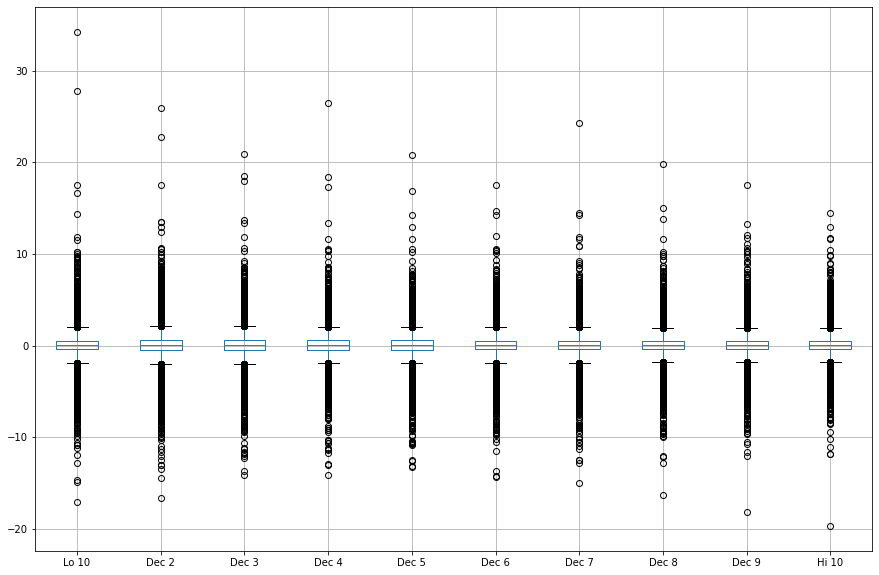

In [1]:
import pandas_datareader.data as web 
import datetime as dt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import linearmodels as lm
from stargazer.stargazer import Stargazer
matplotlib.rcParams['figure.figsize'] = [15, 10]  # setting the plot size

vw_returns = web.DataReader('Portfolios_Formed_on_ME_daily','famafrench', start= 1900)[0] #getting the daily returns 
vw_returns = vw_returns.replace([-99.99,-999], np.nan) #we replace non existing values in the Data
#print(vw_returns)

#It contains value- and equal-weighted returns for size portfolios. Each record contains returns for: 
# Negative (not used) 30% 40% 30%   5 Quintiles  10 Deciles 
# The portfolios are constructed at the end of Jun. The annual returns are from January to December. Missing data are indicated by -99.99 or -999.

#boxplot of value weighted daily returns for each decile portfolio
vw_returns.boxplot(column=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7','Dec 8', 'Dec 9', 'Hi 10']) 

2. For each of the decile portfolios, run a linear regression of the daily returns on dummy variables for the day of the week and print the results.

In [2]:
# We save the different decile portfolio returns in a new DataFrame
vw_returns_dec = vw_returns.loc[:,['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7','Dec 8', 'Dec 9', 'Hi 10']]

#we copy the index column in a new column named 'weekday" and then turn the weekday column into the respective day of the week
vw_returns_dec['weekday'] = pd.to_datetime(vw_returns_dec.index).day_name()
#print(vw_returns_dec)

vw_returns_dec['weekday'] = vw_returns_dec['weekday'].astype('category') #define column 'weekday' as category. This is the column from which we want to get the dummies later
indep = pd.get_dummies(vw_returns_dec['weekday'], prefix='', prefix_sep='') #we get the dummies
indep = indep.drop(columns = 'Saturday', axis=1) #we drop 1 column to prevent perfect multicollinearity
#print(indep)

vw_returns_dec = vw_returns_dec.drop(columns = 'weekday', axis=1) #we drop the column from which we created the dummies originally
y = vw_returns_dec #define dependent regression variable
X = indep #define the independent dummy regression variable
X = sm.add_constant(X) #add an interesct to the regression
#print(X.head())

#We run the regression for every decile separatly
###Regression 1
results_OLS1 = sm.OLS(y['Lo 10'], X).fit()

###Regression 2
results_OLS2 = sm.OLS(y['Dec 2'], X).fit()

###Regression 3
results_OLS3 = sm.OLS(y['Dec 3'], X).fit()

###Regression 4
results_OLS4 = sm.OLS(y['Dec 4'], X).fit()

###Regression 5
results_OLS5 = sm.OLS(y['Dec 5'], X).fit()

###Regression 6
results_OLS6 = sm.OLS(y['Dec 6'], X).fit()

###Regression 7
results_OLS7 = sm.OLS(y['Dec 7'], X).fit()

###Regression 8
results_OLS8 = sm.OLS(y['Dec 8'], X).fit()

###Regression 9
results_OLS9 = sm.OLS(y['Dec 9'], X).fit()

###Regression 10
results_OLS10 = sm.OLS(y['Hi 10'], X).fit()

#Lastly we return the results with stargazer for better data overview
results = [results_OLS1,results_OLS2,results_OLS3,results_OLS4,results_OLS5,results_OLS6,results_OLS7,results_OLS8,results_OLS9,results_OLS10]
stargazer = Stargazer(results)
stargazer

3. Consider only the results for the portfolio of the smallest stocks. Conduct an F test (see documentation of `statsmodels`) to test if the coefficients are jointly significant. Interpret your results.

In [3]:
#We run F test on first decile portfolio returns with null hypothesis "Monday = Tuesday = Wednesday = Thursday = Friday = 0"
print(results_OLS1.f_test("Monday = Tuesday = Wednesday = Thursday = Friday = 0"))

#Interpretation:
# Considering the total significance of the day dummy variables in the previous excercise, the f test does not make total sense as every single 
# variable is significant on its own to the 1% significance level.
# With the F test, as we get a very very small p value, we can reject the null hypothesis and conclude that the independent variables significantly
# describe the dependent variable, which in our case are the returns of the smallest sized portfolios. This is further evidence for the
# significance of our dummy variables in the previous excercise.

<F test: F=65.07972679872367, p=9.625942379210047e-68, df_denom=2.51e+04, df_num=5>


4. Instead of running regressions separately for each portfolio, use a panel regression with portfolio fixed effects to test for the existence of a day of the week effect.

In [4]:
#Since we already have the data, we just need to prepare the data for the panel regression we are supposed to run.
#We need to transform the data to "long format".
vw_returns_mid = X
vw_returns_mid = pd.concat([vw_returns_mid, vw_returns_dec], axis=1) #concatenate returns with dummy DataFrame
vw_returns_mid = vw_returns_mid.reset_index()

#Using the "melt" method, we set our Date, constant and dummy variables as idvars, so the stay untransformed as we create the panel data.
#We define "portfolio" as level 1 index and "return" as the column to stretch into a panel
Data_long = vw_returns_mid.melt(id_vars=['Date','const','Monday','Tuesday','Wednesday','Thursday','Friday'],  var_name='Portfolio', value_name='Return')
Data_long.set_index(['Portfolio','Date'],inplace=True)
#print(Data_long.head(30))

#Lastly we run the regression with return as the dependent variable, the days of the week as independent dummy variables and including an intercept "1"
panel_OLS = lm.PanelOLS.from_formula("Return ~ 1 + Monday + Tuesday + Wednesday + Thursday + Friday + EntityEffects", data=Data_long)
panel_OLS_result = panel_OLS.fit()

print(panel_OLS_result) #Print the results


                          PanelOLS Estimation Summary                           
Dep. Variable:                 Return   R-squared:                        0.0066
Estimator:                   PanelOLS   R-squared (Between):           2.998e-15
No. Observations:              251260   R-squared (Within):               0.0066
Date:                Sun, Jan 23 2022   R-squared (Overall):              0.0066
Time:                        16:08:33   Log-likelihood                -4.029e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      333.76
Entities:                          10   P-value                           0.0000
Avg Obs:                    2.513e+04   Distribution:                F(5,251245)
Min Obs:                    2.513e+04                                           
Max Obs:                    2.513e+04   F-statistic (robust):             333.76
                            

5. The default setting for the standard errors is inappropriate. Consider the results using standard errors clustered (HC3) at the level of the dates. Interpret the results obtained here and in question 4.

In [5]:
#We rerun the regression clustering the standard errors in time (with our data over the respective days)
panel_OLS_clustered = panel_OLS.fit(cov_type="clustered", cluster_time=True)
print(panel_OLS_clustered)

#Interpretation:
# Compared to the results in excercise 2, in excercise 4 the coefficients of the dummy variables are much weaker. This implies that when 
# regressing the dummy variables on the panel data, the statistical significance of the variables sinks. 
# To evidence this, comparing the R squared values of the different regressions, we can see that the R squared of the regression using 
# fixed effects on panel data is much smaller than the R squared of the previous regression on the single portfolio. 
# This result suggests that the dummy variables don't explain the portfolios returns as well in the panel data compared to the individual 
# portfolio regressions.
# By clustering the standard errors at the level of the dates we greatly increase the respective error terms. This means that when clustering
# the standard errors on the respective date (daily), the standard error increases. This finding suggestes that error terms do not correlate in
# respect to the day. Other possible clusters which could improve the error terms instead are the decile portfolios. This strategy would be
# supported by the idea that portfolio returns have a higher correlation within a decile size portfolio instead of over a single specific day, 
# across the different portfolios.

                          PanelOLS Estimation Summary                           
Dep. Variable:                 Return   R-squared:                        0.0066
Estimator:                   PanelOLS   R-squared (Between):           2.998e-15
No. Observations:              251260   R-squared (Within):               0.0066
Date:                Sun, Jan 23 2022   R-squared (Overall):              0.0066
Time:                        16:08:35   Log-likelihood                -4.029e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      333.76
Entities:                          10   P-value                           0.0000
Avg Obs:                    2.513e+04   Distribution:                F(5,251245)
Min Obs:                    2.513e+04                                           
Max Obs:                    2.513e+04   F-statistic (robust):             35.952
                            